In [53]:
from __future__ import annotations

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt

from tqdm import tqdm

import spacy


doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Device:', device)

nlp = spacy.load("en_core_news_sm")
    
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-base-cased-russian-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-base-cased-russian-sentiment").to(device)

Device: mps


In [3]:
BAD_SYMBOLS = ['\xa0', '\n', ',', '.', ';', ':', '!', '?', '(', ')', '—', '…']  

def prepare_text(text_path):
    with open(text_path, 'r') as f:
        text = f.read().lower().strip()
  
    for bas_symbol in BAD_SYMBOLS:
        text = text.replace(bas_symbol, ' ')
    text = ' '.join(text.split()).strip().lower()
    return text

def preprocess_and_prepaer_text(text_path):
    with open(text_path, 'r') as f:
        text = f.read().lower().strip()
  
    for bas_symbol in BAD_SYMBOLS:
        text = text.replace(bas_symbol, ' ')
    doc = nlp(text)
    text = ' '.join([token.lemma_.lower() for token in doc if not token.is_stop])

    return text

In [32]:
text = prepare_text("Детство.txt").split()[:100]

Sentiment trajectory

In [5]:
def prepare_sentiment_trajectory(
    preprocessed_text,
    model,
    tokenizer
) -> list[float]:
    """
    {0: 'neutral', 1: 'positive', 2: 'negative'}
    """
    tokenized_words = []
    for word in tqdm(preprocessed_text):
        inputs = tokenizer(word, return_tensors="pt")
        tokenized_words.append(inputs)
        
    sentiment_traectory = []
    for inputs in tqdm(tokenized_words):
        inputs = inputs.to(device)
        outputs = model(**inputs)
        lprobs = torch.nn.functional.softmax(outputs.logits, dim=1)[0].tolist()
        sentiment_traectory.append(lprobs[1] if lprobs[1] > lprobs[2] else -lprobs[2])
    return sentiment_traectory

In [6]:
sentiment_traectory = prepare_sentiment_trajectory(text, model, tokenizer)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 63.65it/s]


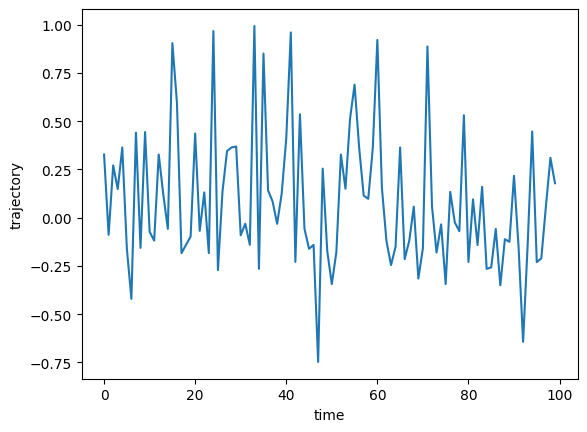

In [7]:
plt.plot(sentiment_traectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

Semantic trajectory

In [46]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(text)

In [55]:
u, s, vT = svds(tfidf_matrix, k=4)